# General Description

This notebook uses R code, please make sure an R kernel is installed for your jupyter notebook or copy the code and run it in an R environment.

This notebook describes the steps for:
* downloading the data
* cleaning the data (subset for E6.5 stage)
* filtering of cells (cell types that are represented by less than 5 cells are filtered out)
* subsetting the dataset randomly for 1500 cells
* normalising data with scran
* filtering genes (genes with mean expression less than 1 in all expressing cells are filtered out)
* generate UMAP of the data

The **output** of this notebook is:
* counts_filtered_norm.txt a normalised (NOT log2 transformed) filtered count matrix (gene names in rows, cell IDs in columns)
* anno_filtered.txt an annotation matrix (containing columns "Cell" and "cell_type").



# Donwload the data
For this analysis, we will use the sinlge cell RNAseq data from [Nowotschin et al, 2019](https://www.nature.com/articles/s41586-019-1127-1). We will analyse the single cell RNAseq data form mouse embryo at E6.5 stage. Please download the raw counts GSM3494341	E6.5_Rep1 and GSM3494342 E6.5_Rep2 at [GEO (GSE123046)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE123046) and the annotation file at https://endoderm-explorer.com -> Downloads -> Text file downloads. Please make sure that you have the following files in your working directory:
1. Lib3-1_E6.5_counts.csv
2. Lib3-2_E6.5_counts.csv
3. sc_endoderm_all_cells_metadata.csv

# Clean data

In [1]:
options(stringsAsFactors = F)

In [2]:
# libraries
require(scran)
require(ggplot2)
require(dplyr)
require(Seurat)
require(umap)

Loading required package: scran

Loading required package: BiocParallel

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colMeans, colSums, colnames,
    dirname, do.call, duplicated, eval, evalq, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, mapply, match, mget,
    o

In [3]:
# Define paths
input.path <- getwd()
print(input.path)
output.path <- input.path
print(output.path)

[1] "/Users/MariaSolovey/Documents/Helmholtz/AG_Scialdone/our_papers/communication/DATASETS/embryo_DanaPeer_GSM3494342/Tutorial_embryo_clustering_revision"
[1] "/Users/MariaSolovey/Documents/Helmholtz/AG_Scialdone/our_papers/communication/DATASETS/embryo_DanaPeer_GSM3494342/Tutorial_embryo_clustering_revision"


In [4]:
# read in coutns
counts1 <- read.csv(paste0(input.path
                          ,"/Lib3-1_E6.5_counts.csv"
                          )
                    ,row.names = 1)
print(dim(counts1))
counts2 <- read.csv(paste0(input.path
                          ,"/Lib3-2_E6.5_counts.csv")
                    ,row.names = 1)
print(dim(counts2))

[1]  8146 18636
[1]  7911 18358


In [5]:
# read in annotation
anno <- read.csv(paste0(input.path
                       ,"/sc_endoderm_all_cells_metadata.csv")
)
dim(anno)

[1] 113051      4

In [6]:
# clean and concatenate counts
# check that the genes are identical in both sets. If not, take only shared genes
identical(colnames(counts1)
          ,colnames(counts2)
          )
intersectGenes <- intersect(colnames(counts1)
                            ,colnames(counts2)
                            )
counts1_sub <- counts1[,colnames(counts1) %in% intersectGenes]
counts2_sub <- counts2[,colnames(counts2) %in% intersectGenes]
identical(colnames(counts1_sub)
          ,colnames(counts2_sub)
)
rownames(counts1_sub) <- paste0("Lib3-1_E6.5_"
                                ,substr(rownames(counts1_sub)
                                        ,3
                                        ,18))

rownames(counts2_sub) <- paste0("Lib3-2_E6.5_"
                                ,substr(rownames(counts2_sub)
                                        ,3
                                        ,18))
counts <- rbind(counts1_sub
                ,counts2_sub)
head(rownames(counts)) # cells
head(colnames(counts)) #genes
dim(counts)

[1] FALSE

[1] TRUE

[1] "Lib3-1_E6.5_TTTATGCTCTAACCGA" "Lib3-1_E6.5_TTTATGCTCAACGGGA"
[3] "Lib3-1_E6.5_TTTATGCTCAGGATCT" "Lib3-1_E6.5_TTTATGCTCGTTACGA"
[5] "Lib3-1_E6.5_TTTATGCTCGGCTTGG" "Lib3-1_E6.5_TTTATGCAGTTTCCTT"

[1] "X0610007P14RIK" "X0610009B22RIK" "X0610009L18RIK" "X0610009O20RIK"
[5] "X0610010F05RIK" "X0610010K14RIK"

[1] 16057 17600

In [7]:
# clean anno
str(anno)
anno_sub <- anno[anno$Timepoint == "E6.5",]
anno_sub$Cell <- as.character(anno_sub$index)
anno_sub$cell_type <- as.character(anno_sub$CellType)
str(anno_sub)
dim(anno_sub)

'data.frame':	113051 obs. of  4 variables:
 $ index    : chr  "E85anterior2A_TTTATGCTCGGATGGA" "E85anterior2A_TTTATGCTCCTAGGGC" "E85anterior2A_TTTATGCTCCAACCAA" "E85anterior2A_TTTATGCAGTGGGTTG" ...
 $ Cluster  : chr  "E8.75_ap: 0" "E8.75_ap: 0" "E8.75_ap:2" "E8.75_ap: 8" ...
 $ Timepoint: chr  "E8.75_ap" "E8.75_ap" "E8.75" "E8.75_ap" ...
 $ CellType : chr  "Mes" "Mes" "Gut tube" "Mes" ...
'data.frame':	9244 obs. of  6 variables:
 $ index    : chr  "Lib3-1_E6.5_TTTATGCTCTAACCGA" "Lib3-1_E6.5_TTTATGCTCAACGGGA" "Lib3-1_E6.5_TTTATGCTCAGGATCT" "Lib3-1_E6.5_TTTATGCTCGTTACGA" ...
 $ Cluster  : chr  "E6.5:6" "E6.5:0" "E6.5:6" "E6.5:2" ...
 $ Timepoint: chr  "E6.5" "E6.5" "E6.5" "E6.5" ...
 $ CellType : chr  "exVE" "exVE" "exVE" "emVE" ...
 $ Cell     : chr  "Lib3-1_E6.5_TTTATGCTCTAACCGA" "Lib3-1_E6.5_TTTATGCTCAACGGGA" "Lib3-1_E6.5_TTTATGCTCAGGATCT" "Lib3-1_E6.5_TTTATGCTCGTTACGA" ...
 $ cell_type: chr  "exVE" "exVE" "exVE" "emVE" ...


[1] 9244    6

In [8]:
# subset counts (delete cells that are not in the annotation: bad cells)
sum(rownames(counts) %in% anno_sub$index) == nrow(anno_sub)

counts_sub <- counts[rownames(counts) %in% anno_sub$index,]
identical(rownames(counts_sub)
          ,as.character(anno_sub$index)
          )
dim(counts_sub)

[1] TRUE

[1] TRUE

[1]  9244 17600

In [9]:
## write files
## TRANSPOSE COUNTS!!
#write.table(t(counts_sub)
#            ,file = paste0(output.path
#                          ,"/E6_5_counts.txt")
#            ,sep = "\t"
#            )
#write.table(anno_sub
#            ,file = paste0(output.path
#                          ,"/E6_5_anno.txt")
#            ,sep = "\t"
#            )

# Filter cells and subset data

In [10]:
options(stringsAsFactors = F)

In [11]:
# Define paths
input.path <- getwd()
print(input.path)
output.path <- input.path
print(output.path)

[1] "/Users/MariaSolovey/Documents/Helmholtz/AG_Scialdone/our_papers/communication/DATASETS/embryo_DanaPeer_GSM3494342/Tutorial_embryo_clustering_revision"
[1] "/Users/MariaSolovey/Documents/Helmholtz/AG_Scialdone/our_papers/communication/DATASETS/embryo_DanaPeer_GSM3494342/Tutorial_embryo_clustering_revision"


In [12]:
## read in raw counts
#counts <- read.csv(paste0(input.path
#                          ,"/E6_5_counts.txt")
#                    ,sep = "\t"
#                    ,row.names = 1
#                    ,check.names = F
#                    )
counts <- t(counts_sub)
dim(counts)

[1] 17600  9244

In [13]:
## read in annotations
#anno <- read.csv(paste0(input.path
#                        ,"/E6_5_anno.txt")
#                 ,sep = "\t"
#)
anno <- anno_sub
dim(anno)

[1] 9244    6

In [14]:
# check correctness
if(!identical(colnames(counts)
          ,anno$Cell)) stop("ERROR: cell IDs are not identical in the count matrix and the ynnotation file")


FILTER CELL TYPES 1: note that we will filter out cell types that have less than 5 cells. (The threshold for filtering the cells was chosen arbitrarily!)

In [15]:
# filter for cells
minNrCells <- 5

cellNr <- table(anno$CellType)
cellNr
cellFilter <- names(cellNr[cellNr >= minNrCells])
cellFilter
idx_cell_filter<- anno$CellType %in% cellFilter
anno_filtered <- anno[idx_cell_filter,]
counts_cell_filtered <- counts[,idx_cell_filter]
dim(anno_filtered)
dim(counts_cell_filtered)



 EPI  Mes   TE emVE exVE 
 461  964  637 2252 4930 

[1] "EPI"  "Mes"  "TE"   "emVE" "exVE"

[1] 9244    6

[1] 17600  9244

RANDOMLY SUBSET DATA FOR 1500 CELLS

In [16]:
set.seed(100)
idx.subset <- sample(1:nrow(anno_filtered)
                    ,1500)
table(anno_filtered$CellType[idx.subset])
sub_anno_filtered <- anno_filtered[idx.subset,]
sub_counts_cell_filtered <- counts_cell_filtered[,idx.subset]
dim(sub_anno_filtered)
dim(sub_counts_cell_filtered)


 EPI  Mes   TE emVE exVE 
  64  147  103  389  797 

[1] 1500    6

[1] 17600  1500

In [17]:
## export annotation files
#write.table(sub_anno_filtered
#            ,file = paste0(output.path
#                           ,"/anno_filtered.txt")
#            ,sep = "\t"
#            )
#write.table(sub_counts_cell_filtered
#            ,file = paste0(output.path
#                           ,"/counts_filtered.txt")
#            ,sep = "\t"
#)

## Normalize data

In [18]:
options(stringsAsFactors = F)

In [19]:
## read in data
#anno <- read.csv(file = paste0(input.path
#                               ,"/anno_filtered.txt")
#                 ,check.names = F
#                 ,sep = "\t")
anno <- sub_anno_filtered
dim(anno)
colnames(anno)
rownames(anno) <- anno$Cell

#counts <- read.csv(file = paste0(input.path
#                                 ,"/counts_filtered.txt")
#                   ,check.names = F
#                   ,row.names = 1
#                   ,sep = "\t")
counts <- sub_counts_cell_filtered
dim(counts)

[1] 1500    6

[1] "index"     "Cluster"   "Timepoint" "CellType"  "Cell"      "cell_type"

[1] 17600  1500

In [20]:
# check cell ID correction
if(!identical(anno$Cell
              ,colnames(counts))) stop("ERROR: cell IDs are not identical in the annotatin and the count table!")


In [21]:
# delete all-zero genes
idx_allZero <- rowSums(counts) == 0
counts_filter <- counts[!idx_allZero,]
dim(counts_filter)

[1] 16476  1500

In [22]:
# check correctness
if(!identical(anno$Cell
              ,colnames(counts_filter))) stop("ERROR: cell IDs are not identical in the annotation and the counts after filtering!")



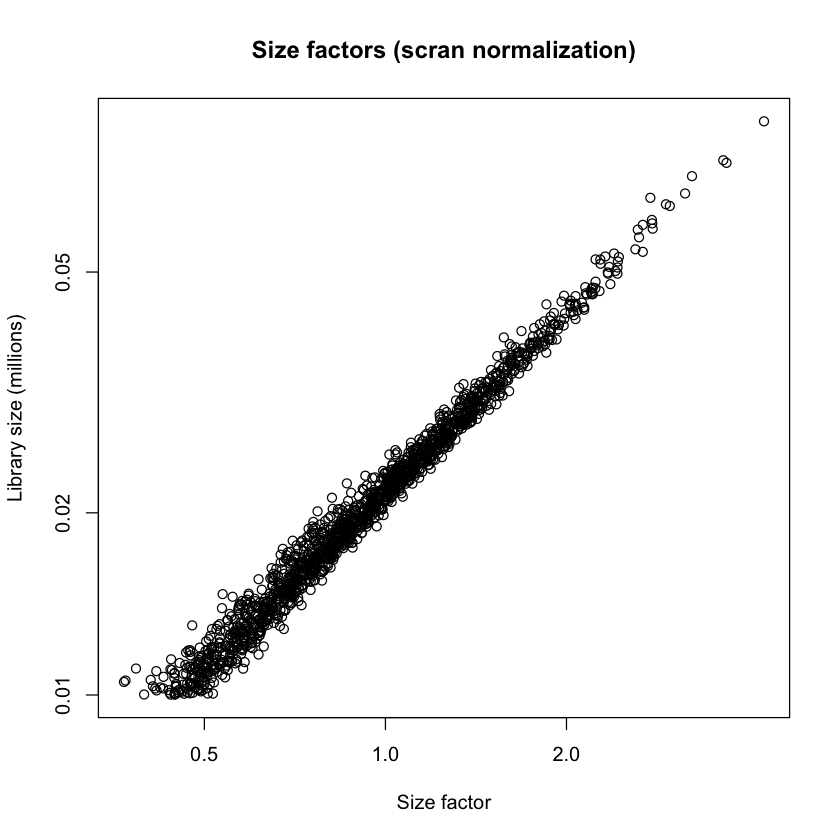

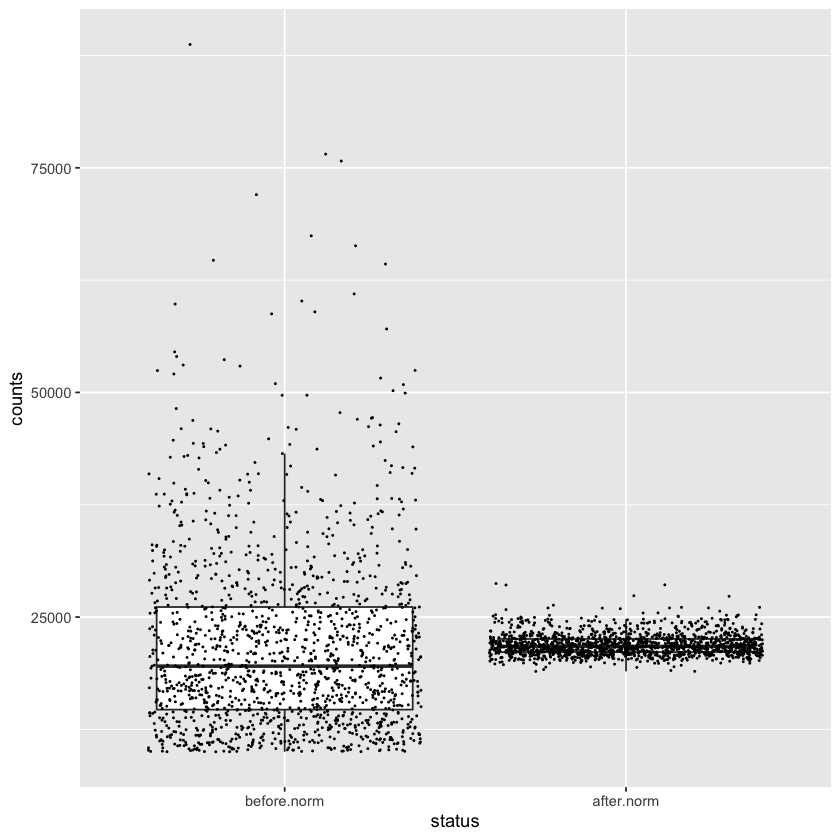

In [23]:
# create SingleCellExperiment object
original_sce <- SingleCellExperiment(
        assays = list(counts = as.matrix(counts_filter))
        ,colData = anno
)
# comupte size factors
original_sce <- computeSumFactors(original_sce)
plot(sizeFactors(original_sce)
     , colSums(counts(original_sce))/1e6, log="xy"
     ,ylab="Library size (millions)", xlab="Size factor"
     ,main = "Size factors (scran normalization)")
# normalize
original_sce <- normalize(original_sce)
if("patientID" %in% colnames(anno)){
        {df <- data.frame(counts = colSums(exprs(original_sce))
                          ,patientID = original_sce$patientID)
        ggplot(data = df
               ,aes(y = counts
                    ,x = patientID)
        ) +
                geom_boxplot(outlier.shape = NA) + 
                geom_jitter(pch = 16, size = 0.5)+
                labs(title = "scran normalized data")
        }
}
# plot 
{
        df <- data.frame(counts = c(colSums(counts_filter)
                                    ,colSums(2^exprs(original_sce)-1)
                                    )
                         ,status = c(rep("before.norm"
                                       ,ncol(counts_filter)
                                       )
                                   ,rep("after.norm"
                                        ,ncol(exprs(original_sce)
                                              )
                                        )
                                   )
                         )
        df$status <- factor(df$status
                          ,levels = c("before.norm"
                                      ,"after.norm"
                                      )
                          ,labels = c("before.norm"
                                      ,"after.norm"
                          )
                          ,ordered = T
                          )
        ggplot(data = df
               ,aes(x = status
                    ,y = counts)
               ) + 
                geom_boxplot(outlier.shape = NA) + 
                geom_jitter(pch = 16, size = 0.5)
}

In [24]:
## export
## counts
#write.table(2^exprs(original_sce)-1 # we don't need the log2 transformation for the dwonstream analysis
#            ,file = paste0(output.path
#                           ,"/counts_filtered_norm.txt")
#            ,sep = "\t")



# Filter genes (x2)
We will filter out genes that have mean mormalized expression (in cells expressing the gene) less or equal 1.

In [25]:
options(stringsAsFactors = F)

X0610007P14RIK X0610009B22RIK X0610009L18RIK X0610009O20RIK X0610010F05RIK 
     2.0939472      1.9197112      0.9580304      1.1991858      1.2103208 
X0610010K14RIK 
     1.1103423

[1] "There are 14160 genes with more than 1 transcript"


[1] 16476  1500

[1] 14160  1500

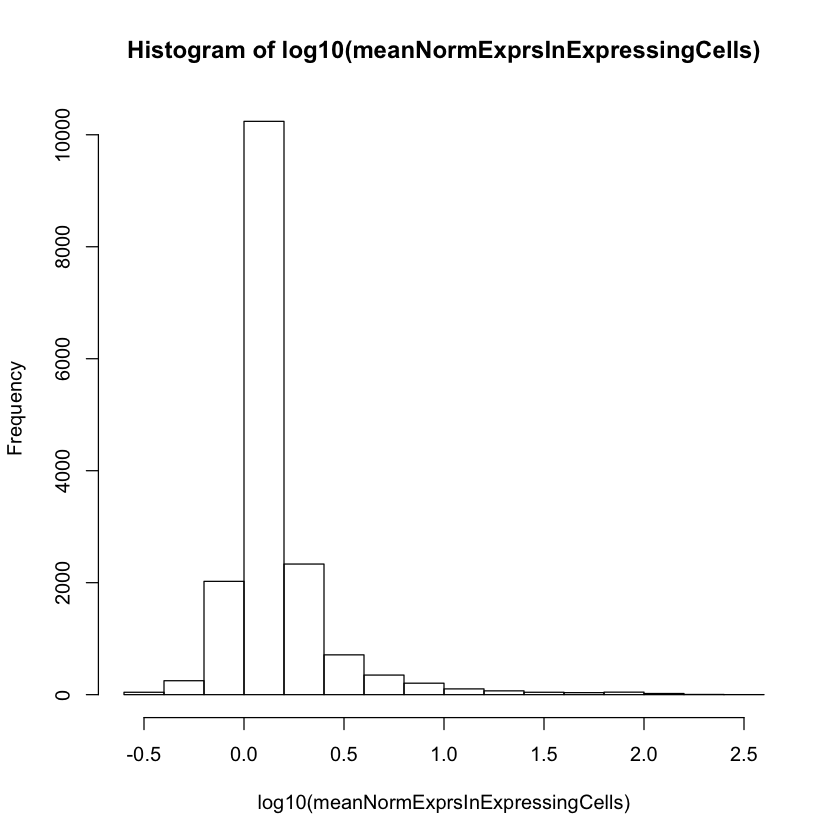

In [26]:
## read in normalized counts
#norm_exprs <- read.csv(paste0(input.path
#                          ,"/counts_filtered_norm.txt")
#                       ,sep = "\t"
#                       ,check.names = F
#                       ,row.names = 1
#                      )
norm_exprs <- 2^exprs(original_sce)-1 # we don't need the log2 transformation for the dwonstream analysis

# calculate mean normalized expression only in cells that express a gene
isExpressing <- norm_exprs != 0
# delete all zero genes
norm_exprs_filtered <- norm_exprs[rowSums(isExpressing) != 0,]
isExpressing <- isExpressing[rowSums(isExpressing) != 0,]

# calculate means in expressing cells
meanNormExprsInExpressingCells <- {
    counts <- norm_exprs_filtered
    counts[counts == 0] <- NA
    rowMeans(counts, na.rm=T)
}
head(meanNormExprsInExpressingCells)

# plot 
hist(log10(meanNormExprsInExpressingCells))

print(paste("There are"
      ,sum(meanNormExprsInExpressingCells > 1)
      ,"genes with more than 1 transcript"))

# The general low level of expression is most probably due to the UMI method. 
# For this reason we can use liberal thresholds.

exprsThreshold <- 1
filterGenes <- meanNormExprsInExpressingCells > exprsThreshold
norm_exprs_filtered <- norm_exprs_filtered[filterGenes,]
dim(norm_exprs)
dim(norm_exprs_filtered)

In [27]:
# export
write.table(norm_exprs_filtered
            ,file = paste0(output.path
                           ,"/counts_filtered_norm.txt")
            ,sep = "\t")
# export annotation files
write.table(anno
            ,file = paste0(output.path
                           ,"/anno_filtered.txt")
            ,sep = "\t"
            )

# UMAP of the data

[1] "GOLGA3" "MESP1"  "TULP3"  "S100G"  "GM1673" "CER1"   "AGL"    "TMSB10"
 [9] "PHLDA2" "TDGF1"


 EPI  Mes   TE emVE exVE 
  64  147  103  389  797 

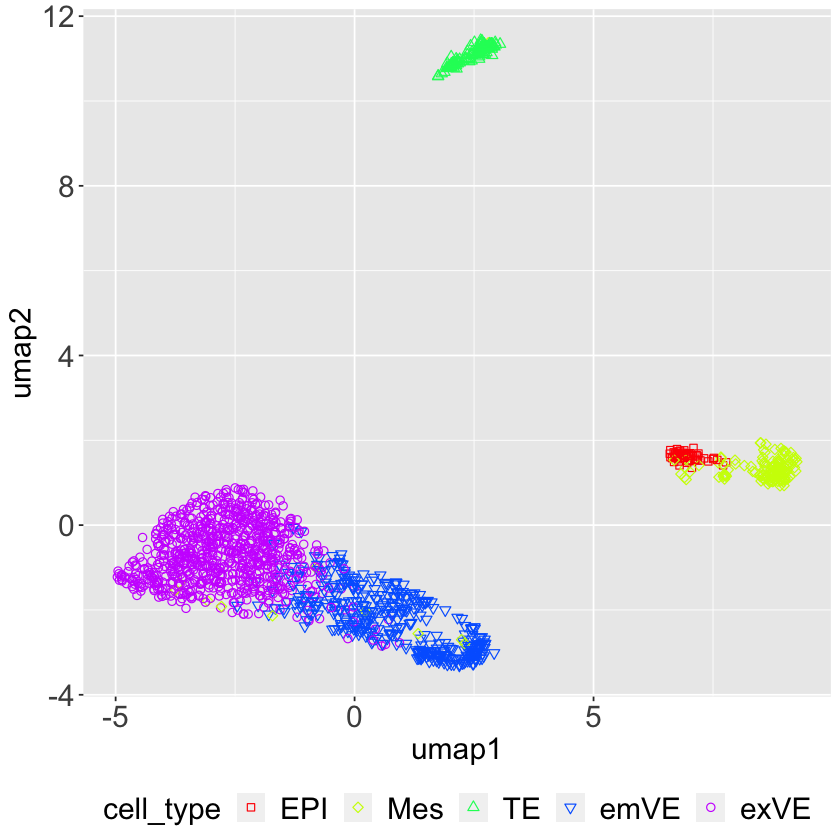

In [28]:
# calcualte HVG
seurat.obj <- CreateSeuratObject(counts = norm_exprs # NOTE: this is already normalized data!
                           )
# identify HVGs
seurat.obj <- FindVariableFeatures(seurat.obj, selection.method = "vst", nfeatures = 2000)
# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(seurat.obj), 10)
top10

HVG <- seurat.obj@assays$RNA@var.features

# make dissimilarity matrix
# Calculate distance matrix
chosen.exprs <- norm_exprs[HVG,]
# Calculate distance matrix between cells
dissimMatrix <- sqrt((1-cor(chosen.exprs, method = "spearman"))/2)

# calculate UMAP
fontsize <- 18
set.seed(100)
custom.settings <-  umap.defaults
custom.settings$input <- "dist"
my.umap <- umap(dissimMatrix
                ,config = custom.settings
                )

# prepare dataframe for plotting
dfForUmap <- data.frame(x=my.umap$layout[,1]
                        ,y=my.umap$layout[,2]
                        ,cell_type=anno$cell_type
)
dfForUmap$cell_type <- as.factor(dfForUmap$cell_type)
cell_type.col <- structure(rainbow(length(levels(dfForUmap$cell_type))))
names(cell_type.col) <- levels(dfForUmap$cell_type)

cell_type.shape <- c(1:length(cell_type.col)) %% 5 +21
names(cell_type.shape) <- names(cell_type.col)

# plot UMAP
umap.clusters <- ggplot(dfForUmap
                        , aes(x=x
                              ,y=y
                              ,color=cell_type
                              ,shape = cell_type
                        )
)+
        geom_point(size=2) +
        scale_color_manual(name = "cell_type"
                           ,labels = names(cell_type.col)
                           ,values = cell_type.col) +
        scale_shape_manual(name = "cell_type"
                           ,labels = names(cell_type.shape)
                           ,values = cell_type.shape) +
        ylab("umap2") +
        xlab("umap1") +
        #ggtitle("umap of ligand-receptor pairs") +
        theme(legend.position="bottom"
              ,axis.title = element_text(size = fontsize)
              ,axis.text = element_text(size = fontsize)
              ,legend.text = element_text(size = fontsize)
              ,legend.title = element_text(size = fontsize)
        ) +
        guides(fill=guide_legend(nrow=2
                                 ,direction = "horizontal"
                                 ,title.position = "top"
                                 ,label.position= "bottom"
                                 ,byrow=TRUE
        )
        )
print(umap.clusters)
table(dfForUmap$cell_type)